## Time series of average reviewer ratings and movie sales

In this notebook, we explore the time series of:
1. Average reviewer rating 
2. Daily box-office movie sales


In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import random
import json
import statsmodels.graphics.tsaplots as tsaplots
import pymc as pm

In [2]:
# from pyquery import PyQuery as pq
from bs4 import BeautifulSoup
# The "requests" library makes working with HTTP requests easier
# than the built-in urllib libraries.
import requests
from datetime import datetime
from dateutil import parser
from collections import Counter
from itertools import groupby

## 1. Average reviewer ratings as a function of time

In [3]:
results_users = []

#First, I need to get the number of pages of reviews
# page=requests.get("http://www.rottentomatoes.com/m/batman_v_superman_dawn_of_justice/reviews/?type=user")
page=requests.get("http://www.rottentomatoes.com/m/spectre_2015/reviews/?type=user")

soup = BeautifulSoup(page.text, "html.parser")
number_of_pages = soup.find("span", attrs={"class":"pageInfo"}).get_text().split()[-1]

#run through the number of user pages
for x in range(int(number_of_pages)):
    try:
#         page=requests.get("http://www.rottentomatoes.com/m/batman_v_superman_dawn_of_justice/reviews/?page="+str(x+1)+"&type=user&sort=")
        page=requests.get("http://www.rottentomatoes.com/m/spectre_2015/reviews/?page="+str(x+1)+"&type=user&sort=")
        soup = BeautifulSoup(page.text, "html.parser")

        page_reviews = soup.find("div", attrs={"class":"review_table"}).find_all("div", attrs={"class":"row review_table_row"})
        for review in page_reviews:

            #Check get the number of stars
            stars = review.find_all("span", attrs ={"class":"glyphicon glyphicon-star"})


            review_date = review.find("span", attrs ={"class":"fr small subtle"}).get_text() 
            dt = parser.parse(review_date).date()  #convert it into python datetime format
            results_users.append((dt, len(stars) ))
            
    #rotten tomatoes does not show all the user ratings. after a certain point, it stops
    except Exception as e:
        print "Breaking at page:", x+1
        break

    #pause for a while
    time.sleep(1)



Breaking at page: 53


In [4]:
results_users.sort()
data_users = {}
for data in results_users:
    if data[0].month < 10:
        month = '0'+str(data[0].month)
    else:
        month = str(data[0].month)
    if data[0].day < 10:
        day = '0'+str(data[0].day)
    else:
        day = str(data[0].day)
    key = str(data[0].year)+month+day
    if key not in data_users.keys():
        data_users[key] = data[1]
    else:
        data_users[key] = np.hstack((data_users[key], data[1]))

In [5]:
min_num = 2
rating_avg = {}
for i in data_users:
    if type(data_users[i]) is not int and len(data_users[i]) >= min_num:
        rating_avg[i] = np.mean(data_users[i])

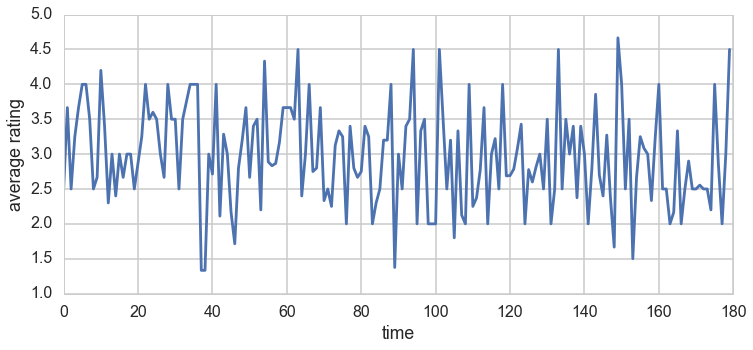

In [6]:
plt.figure(figsize=[12,5])
plt.plot(rating_avg.values())
plt.xlabel('time')
plt.ylabel('average rating')

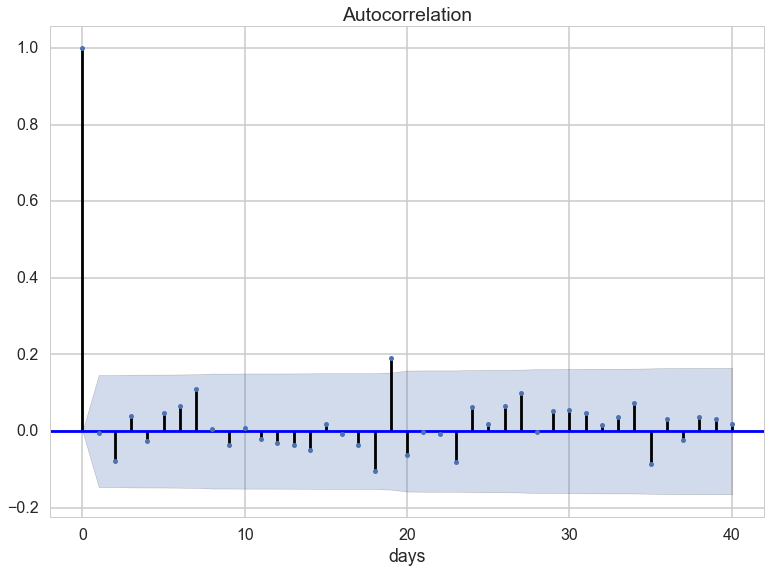

In [10]:
tsaplots.plot_acf(rating_avg.values(), lags=40);
plt.xlabel('days')

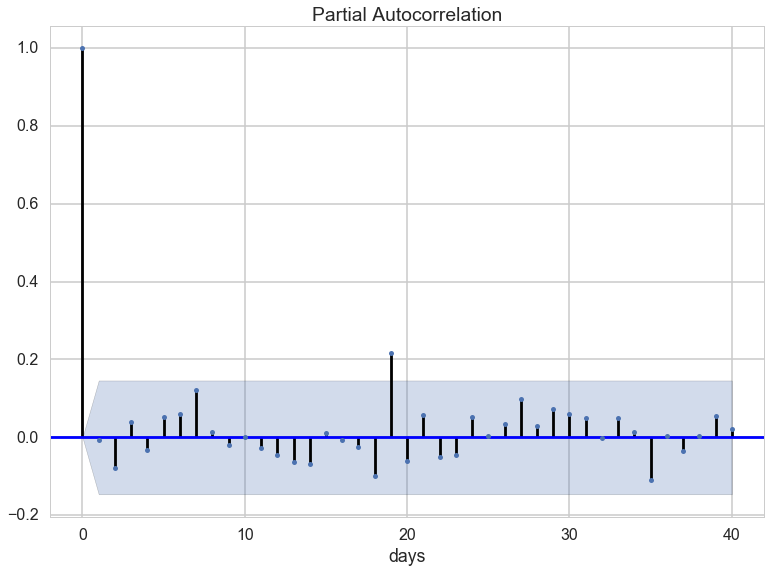

In [9]:
tsaplots.plot_pacf(rating_avg.values(), lags=40)
plt.xlabel('days')

The average rating on one day seems to be independent from that on previous days.

## 2. Box Office Movie Sales

In [11]:
results_box_office = []
#page=requests.get("http://www.boxofficemojo.com/movies/?page=daily&view=chart&id=superman2015.htm")
page=requests.get("http://www.boxofficemojo.com/movies/?page=daily&view=chart&id=starwars7.htm")
#page=requests.get("http://www.boxofficemojo.com/movies/?page=daily&view=chart&id=avatar.htm")
#page=requests.get("http://www.boxofficemojo.com/movies/?page=daily&view=chart&id=passionofthechrist.htm")
#page=requests.get("http://www.boxofficemojo.com/movies/?page=daily&view=chart&id=mybigfatgreekwedding.htm")
soup = BeautifulSoup(page.text, "html.parser")
tables = soup.find("table", attrs={"class":"chart-wide"})

rows = tables.find_all("tr", attrs={"bgcolor":"#ffffff"}) + tables.find_all("tr", attrs={"bgcolor":"#f4f4ff"})
for row in rows:
    row_splitted = row.find_all("td")
    date = parser.parse(row_splitted[1].get_text()).date()  #1 correspond to date information
    gross = int(row_splitted[3].get_text()[1:].replace(',', ''))
    results_box_office.append((date, gross))
    
results_box_office.sort()
#print results_box_office

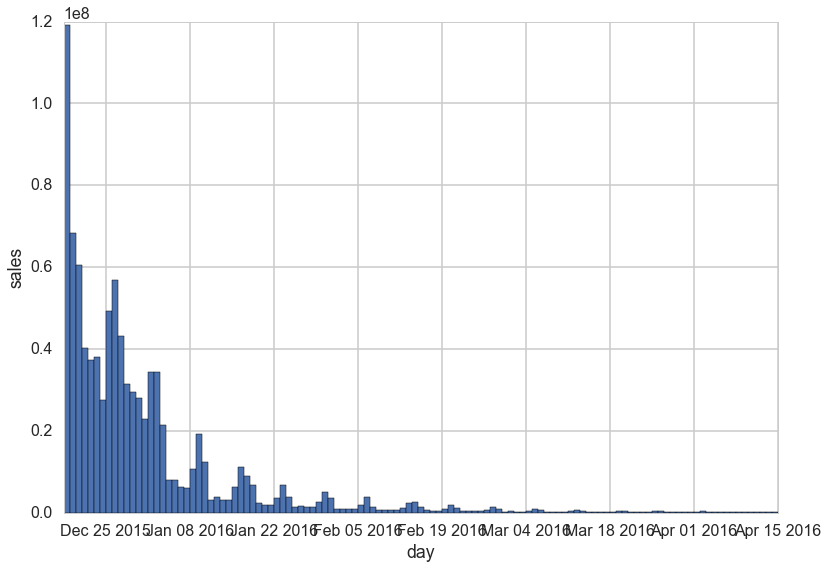

In [12]:
x = [date for date,gross in results_box_office ]
y = [gross for date,gross in results_box_office ]

ax = plt.subplot(111)
ax.bar(x, y, width=1)
ax.xaxis_date()
plt.xlabel('day')
plt.ylabel('sales')
plt.show()


Box office sales data always has an exponential decrease, and peaks due to weekends. We first converted the above raw data into a stationary form by removing these factors.

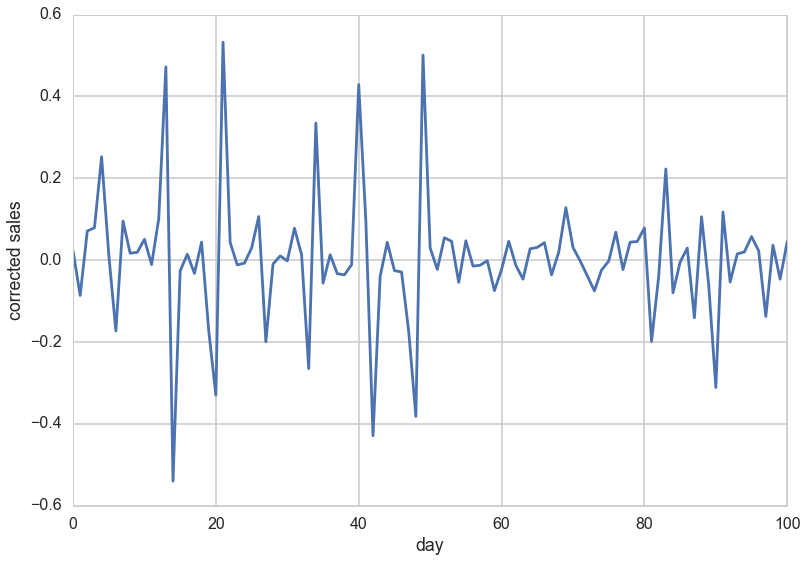

In [15]:
# Converting box-office sales into stationary time-series
deltaloggross = np.log10(y[1::])-np.log10(y[0:-1])
newy = deltaloggross[7::]-deltaloggross[:-7]

plt.figure
plt.plot(newy[10::])
plt.xlabel('day')
plt.ylabel('corrected sales')
plt.show()


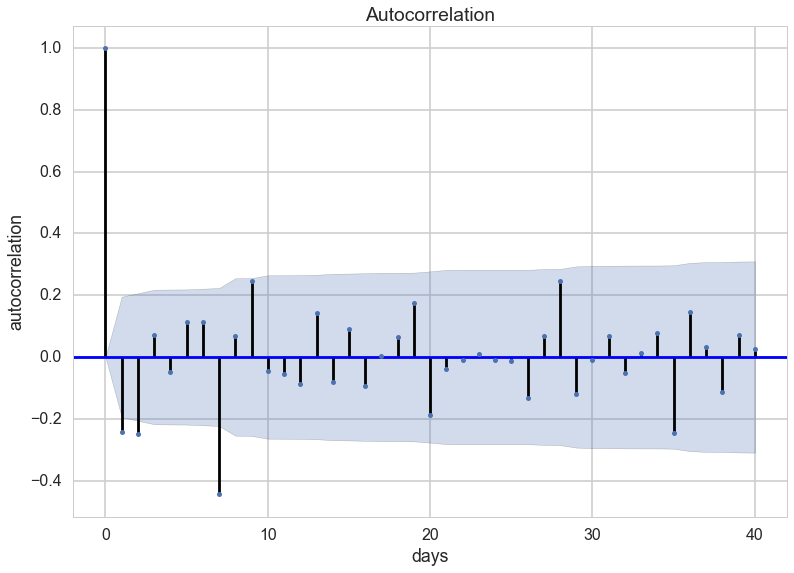

In [17]:
tsaplots.plot_acf(newy[10::], lags=40);
plt.xlabel('days')
plt.ylabel('autocorrelation')

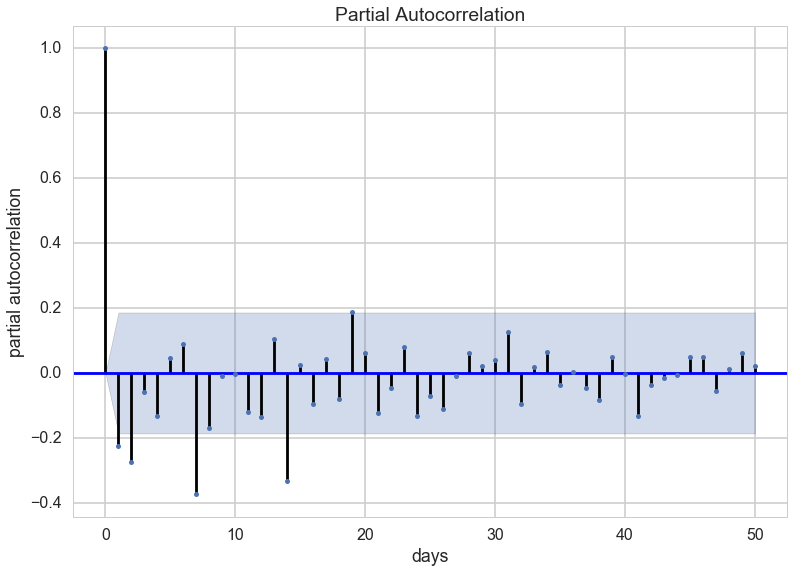

In [16]:
tsaplots.plot_pacf(newy, lags=50)
plt.xlabel('days')
plt.ylabel('partial autocorrelation')

Again, the movie sales on one day is independent from that on previous days.